# PDF 解析实践

## pdfplumber

https://github.com/jsvine/pdfplumber

pdfplumber 是一个用于解析 PDF 文档的 Python 库。它提供了一种简单而高效的方式来提取和操作 PDF 文档中的文本、图像和表格。

In [ ]:
import pdfplumber
import pandas as pd


### 基础功能

使用 extract_text 函数提取全部文本

  > x_tolerance 是 x 方向上的容差，两个字符之间的距离小于 x_tolerance 时认为它们属于一个单词。

In [ ]:
with pdfplumber.open("./assets/example2.pdf") as pdf:
    first_page = pdf.pages[0]  # 获取第一页
    text = first_page.extract_text(x_tolerance=2, y_tolerance=3)  # 提取全部文本
    print(text)

使用 `extract_words` 函数提取单词，同时还可以获取每个单词的位置信息。

In [ ]:
with pdfplumber.open("./assets/example2.pdf") as pdf:
    first_page = pdf.pages[0]  # 获取第一页
    words = first_page.extract_words(x_tolerance=2, y_tolerance=3)  # 提取全部单词
    print(words)

提取表格

In [37]:
with pdfplumber.open("./assets/example3_5.pdf") as pdf:
  page = pdf.pages[0]
  # 基础表格提取
  tables = page.find_tables()
  table = tables[2].extract()
  table_df = pd.DataFrame(table[1:], columns=table[0])

### 处理合并单元格

- ffill: 使用缺失值前面最近的一个非缺失值来填充该缺失值
- bfill: 使用缺失值后面最近的一个非缺失值来填充该缺失值

此方法能处理行的的合并单元格，但横向的合并单元格无法处理（而且存在错误填充的情况）。

In [38]:
table_df_f = table_df.ffill()
table_df_b = table_df.bfill()

PDF
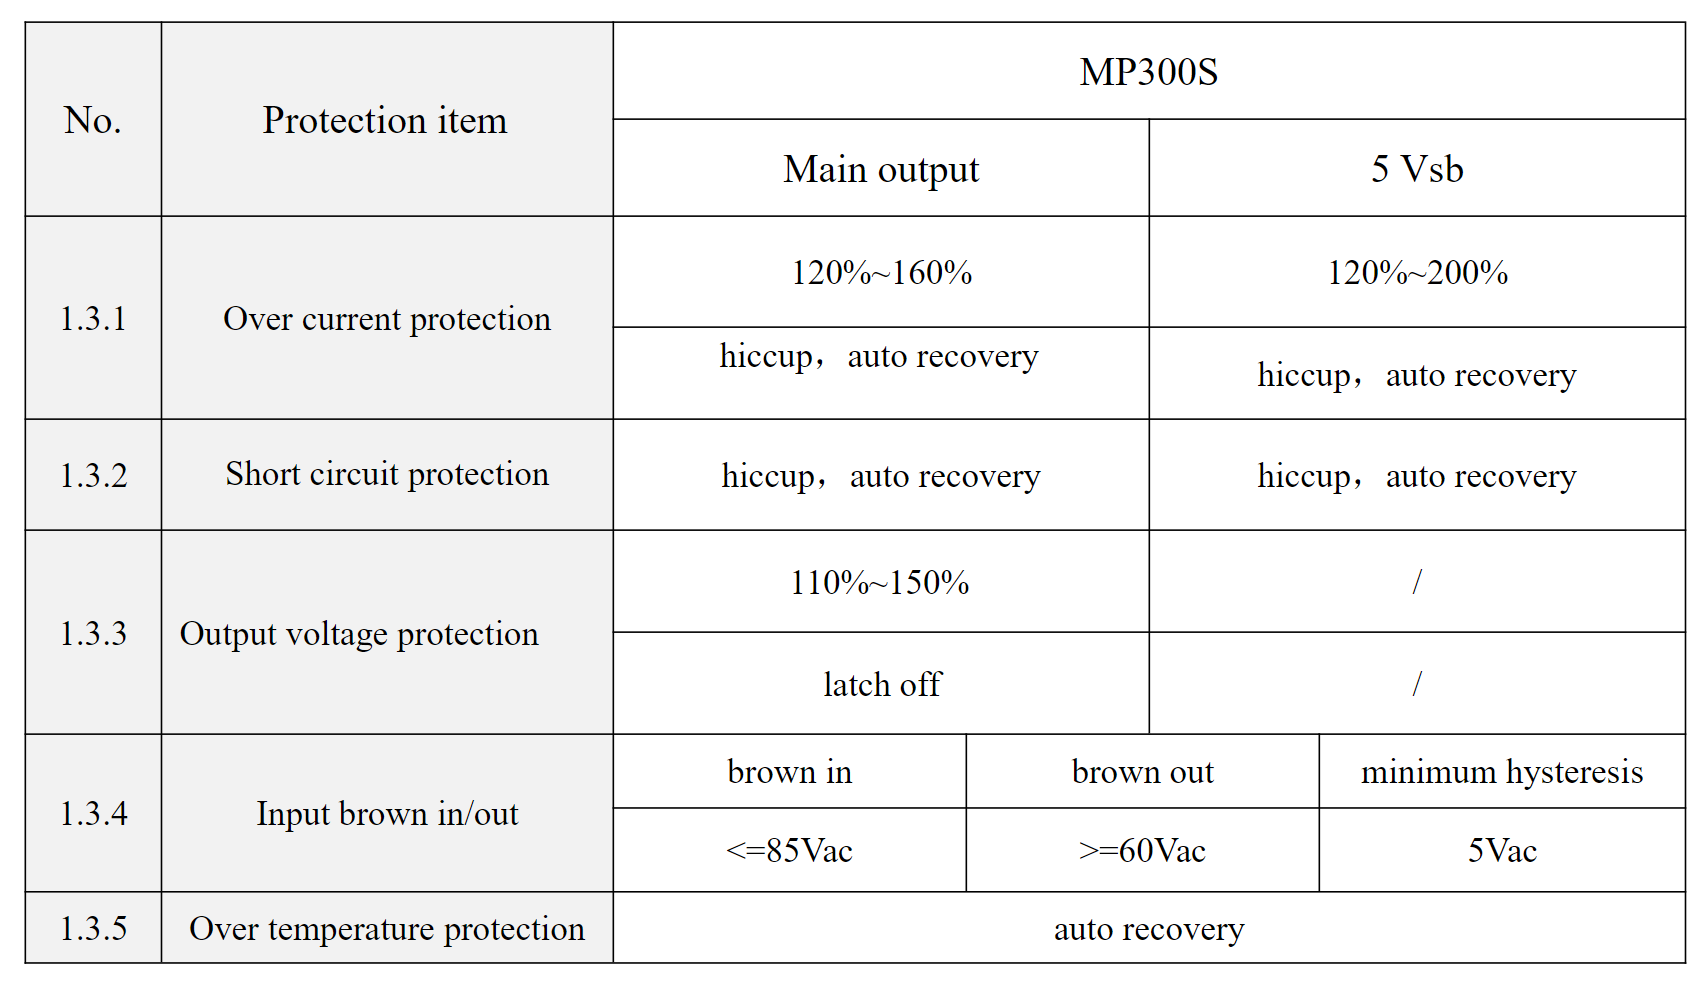

原数据
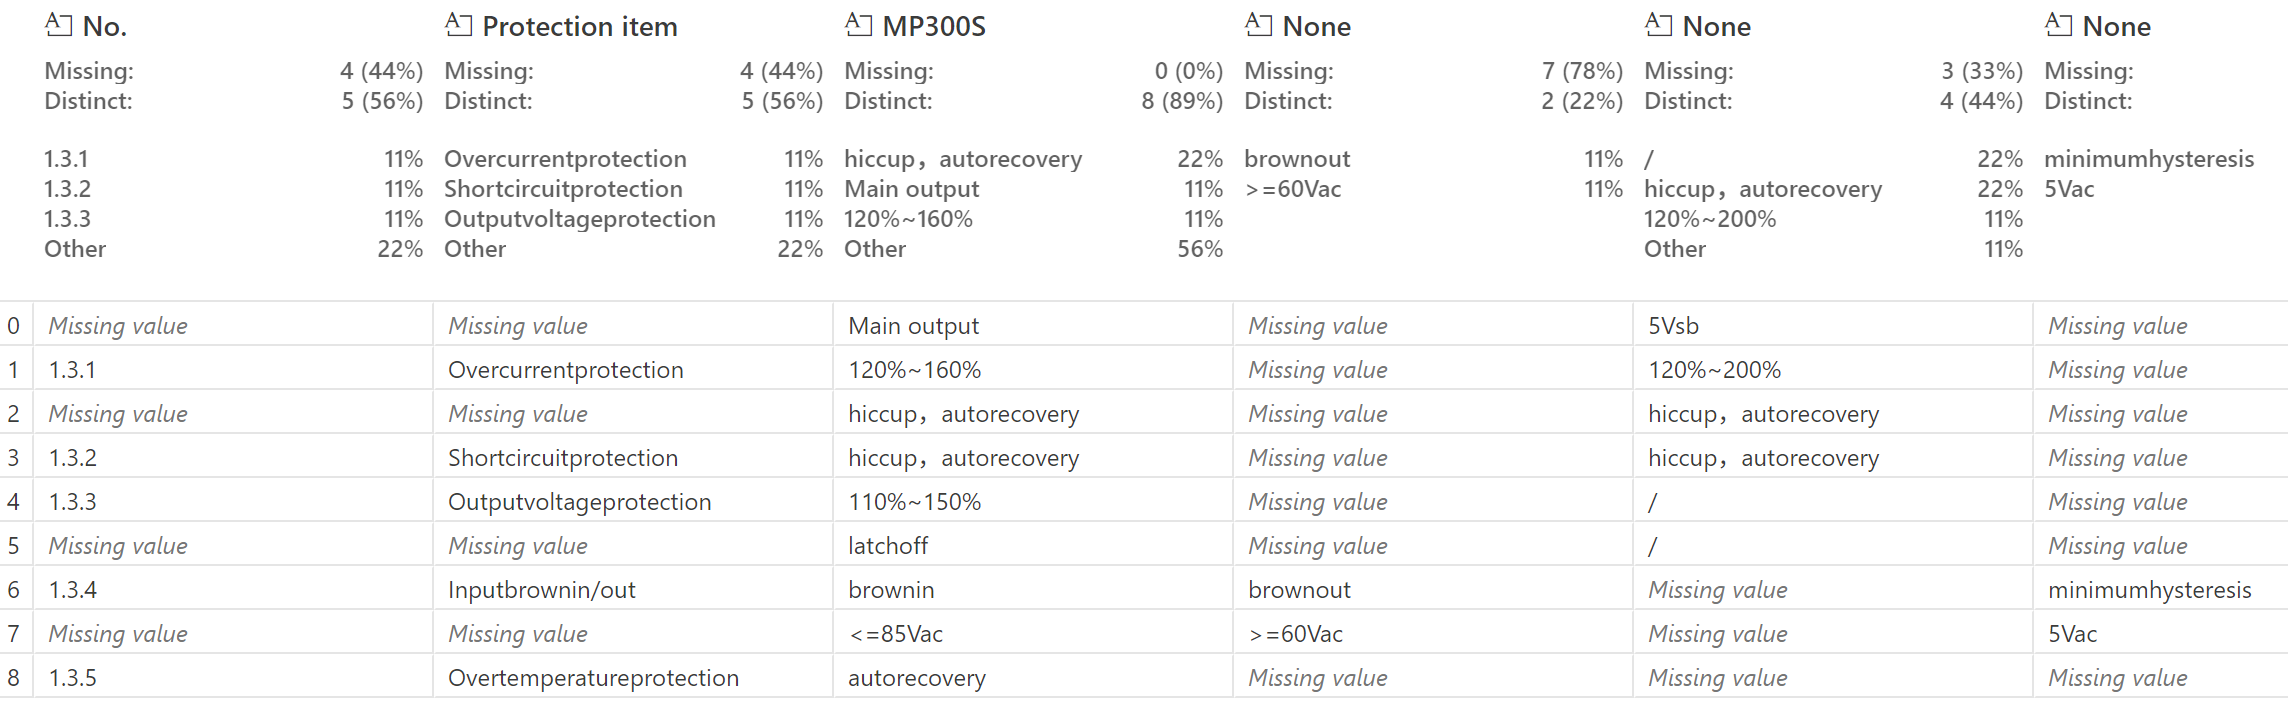

ffill
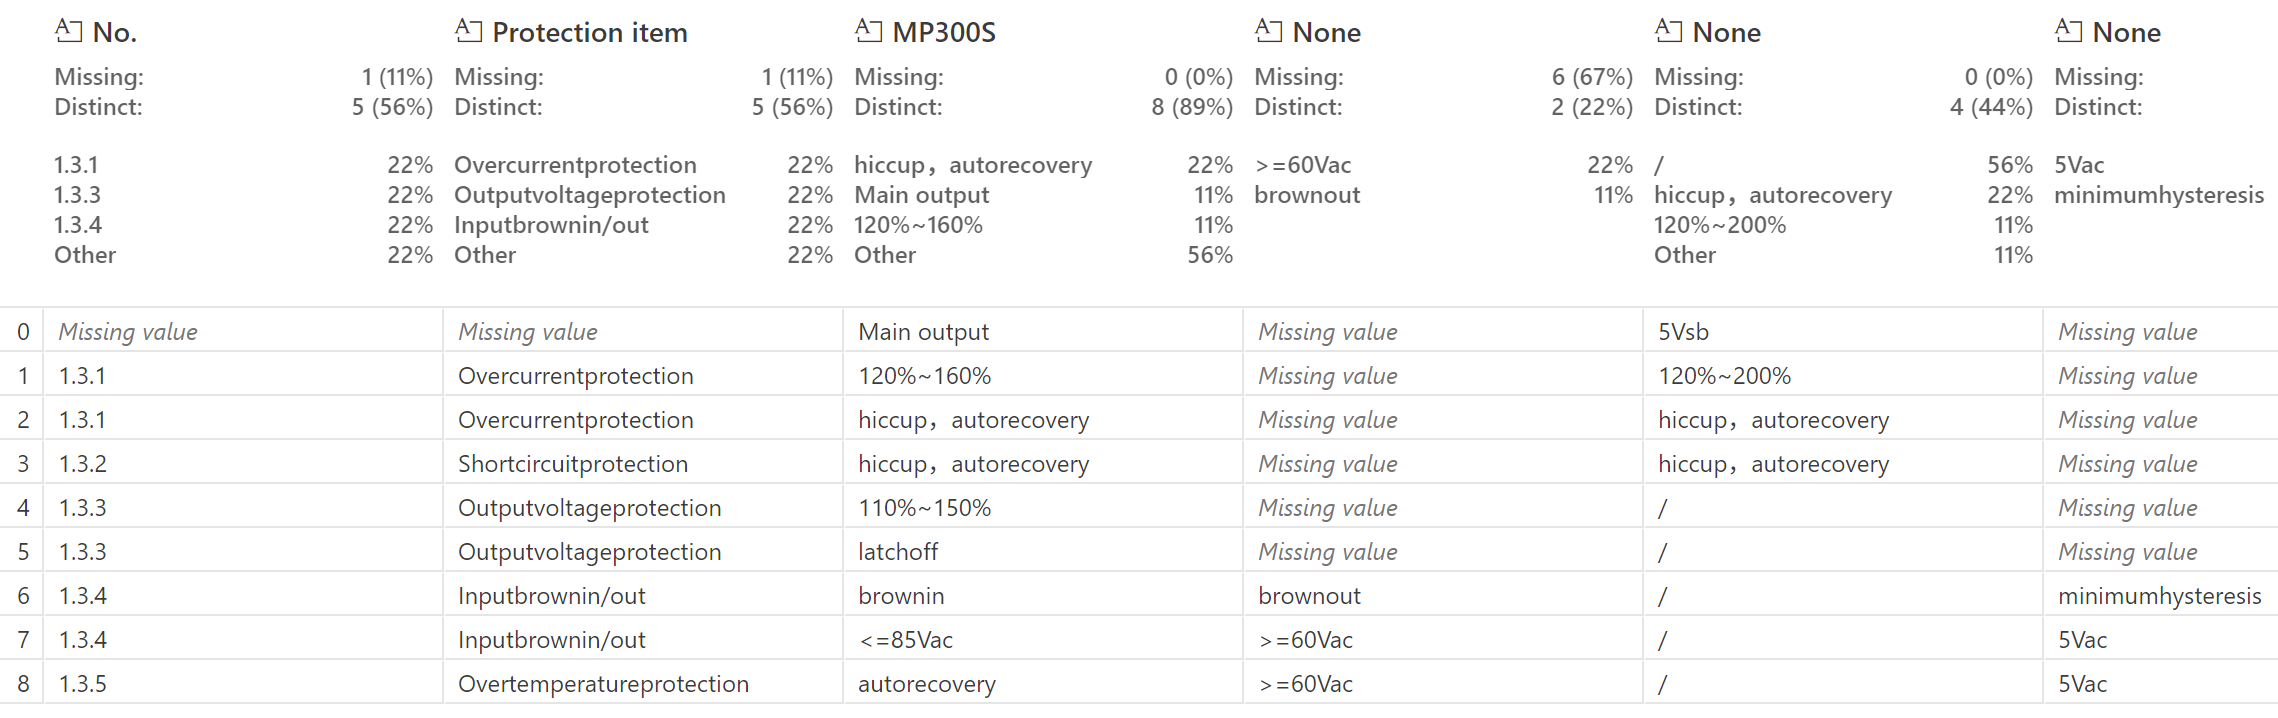

### 同时提取 文字、表格、图片

`extract_text` 和 `extract_table` 都能提取到表格中的文字，造成重复提取，需要在提取文本时排除已经被识别为表格的部分，以避免重复。

此外，pdfplumber 还支持提取图片资源与信息，上传到云存储便于后续检索。

In [ ]:
def extract_elements(pdf_path):
    elements = []
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages):
            # 提取表格区域坐标
            tables = page.find_tables()
            table_bboxes = [table.bbox for table in tables]
            
            # 提取文本块（过滤表格区域）
            text_blocks = []
            words = page.extract_words(x_tolerance=2, y_tolerance=3)
            current_line = []
            for word in words:
                # 判断是否在表格区域内[1,7](@ref)
                if any(word["x0"] >= bbox[0] and word["x1"] <= bbox[2] and 
                       word["top"] >= bbox[1] and word["bottom"] <= bbox[3] 
                       for bbox in table_bboxes):
                    continue
                
                # 合并成行
                if not current_line:
                    current_line.append(word)
                else:
                    last_word = current_line[-1]
                    if abs(word["top"] - last_word["top"]) < 2:
                        current_line.append(word)
                    else:
                        text_blocks.append({
                            "text": " ".join([w["text"] for w in current_line]),
                            "top": current_line[0]["top"]
                        })
                        current_line = [word]
            if current_line:
                text_blocks.append({
                    "text": " ".join([w["text"] for w in current_line]),
                    "top": current_line[0]["top"]
                })
            
            # 添加元素
            elements.extend([
                {"type": "text", "content": tb["text"], "page": page_num, "y": tb["top"]} 
                for tb in text_blocks
            ])
            
            # 添加表格
            for table in tables:
                df = pd.DataFrame(table.extract()[1:], columns=table.extract()[0])
                elements.append({
                    "type": "table", 
                    "content": df.to_markdown(index=False),
                    "page": page_num,
                    "y": table.bbox[1]
                })

            # 添加图片
            for image in page.images:
                elements.append({
                    "type": "image",
                    # 上传图片到图床，返回图片链接 f'[Image]({url})'
                    "content": f'[Image](url)',
                    "page": page_num,
                    "y": image["top"]
                })
                
            
    return elements

def sort_elements(elements):
    # 按页码->垂直位置->水平位置排序[3,7](@ref)
    sorted_elements = sorted(elements, key=lambda x: (x["page"], x["y"], x.get("x0",0)))
    
    # 处理分栏布局（以两栏为例）
    final_order = []
    current_page = -1
    column_threshold = None
    
    for elem in sorted_elements:
        if elem["page"] != current_page:
            current_page = elem["page"]
            # 计算分栏阈值（假设页面宽度为A4：595pt）
            column_threshold = 595 / 2 - 20  # 留20pt边距
            
        # 判断是否属于右栏
        if elem.get("x0", 0) > column_threshold:
            # 延迟到左栏内容之后插入
            final_order.append(("right", elem))
        else:
            final_order.append(("left", elem))
    
    # 重组分栏内容
    output = []
    left_buffer, right_buffer = [], []
    for pos, elem in final_order:
        if pos == "left":
            if right_buffer:
                output.extend(right_buffer)
                right_buffer = []
            output.append(elem)
        else:
            right_buffer.append(elem)
    output.extend(right_buffer)
    return output

def pdf_to_md(pdf_path):
    elements = extract_elements(pdf_path)
    sorted_elements = sort_elements(elements)
    
    # 输出Markdown
    md = ""
    for elem in sorted_elements:
        if elem["type"] == "text":
            md += f"{elem['content']}\n\n"
        elif elem["type"] == "table":
            md += f"{elem['content']}\n\n"
    return md

In [ ]:
print(pdf_to_md("./assets/example2.pdf"))

### 真实文档测试

测试文档为麦格米特 P34 MP300S-SPEC产品规格书.pdf

原文件是`./assets/example3.pdf`，为便于观察，已将 pdf 按页分割为多个pdf文件，其中

- example3_2.pdf 包含换行TD
- example3_9.pdf 包含合并单元格表格


In [ ]:
import os

output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(f'{output_dir}/result.md', 'w', encoding='utf-8') as f:
    f.write(pdf_to_md('./assets/example3_9.pdf'))

### pdfplumber 特性分析

- 支持字符级别的信息提取，但需要自行处理段落、标题等信息。
- 具备提取表格能力，但无法自动处理跨页表格及复杂的合并单元格。
- 通过微调提取参数以及特定后处理，可以实现高质量提取，适合大批量格式统一的文档。
- 不支持扫描件。

总结：pdfplumber 适合处理格式固定的文档，但需要手动处理段落、标题等信息，以及手动处理表格内部的换行。

## tabula-py

https://github.com/chezou/tabula-py

基于 tabula-java 构建的一种用于从 PDF 文件中提取表格的工具。使用前要确保 java 环境已经安装。

In [33]:
import os
import tabula

print(os.getenv('JAVA_HOME')) # tabula 依赖此环境变量

dfs = tabula.read_pdf("./assets/example3_9.pdf", pages='all', multiple_tables=True)
content = '\n\n'.join([df.to_markdown(index=False) for df in dfs]).replace('nan', '   ')

output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(f'{output_dir}/result_tabula.md', 'w', encoding='utf-8') as f:
    f.write(content)

C:\Program Files\Java\jdk-24


In [ ]:
tabula.convert_into("./assets/example3_9.pdf", "./output/result.csv", output_format="csv", pages='all')

提取效果与 pdfplumber 基本一致

## 大模型方案

### olmocr
https://olmocr.allenai.org/

硬件需求：
- Recent NVIDIA GPU (tested on RTX 4090, L40S, A100, H100) with at least 20 GB of GPU RAM
- 30GB of free disk space

解析效果：存在行列分割错误、丢数据现象。

<table>
<thead>
<tr>
<th>PIN</th>
<th>Terminal model</th>
<th>Matching terminals and plastic shell</th>
</tr>
</thead>
<tbody><tr>
<td>CN100</td>
<td>1 PE</td>
<td>VH-5ADW3 (华富(嘉得电子)) (Or equivalent)</td>
</tr>
<tr>
<td></td>
<td>3 N</td>
<td></td>
</tr>
<tr>
<td></td>
<td>5 L</td>
<td></td>
</tr>
<tr>
<td>CN201</td>
<td>1 VOUT+</td>
<td>M4 OUTPUT TERMINAL</td>
</tr>
<tr>
<td>CN202</td>
<td>1 VOUT-</td>
<td>M4 OUTPUT TERMINAL</td>
</tr>
<tr>
<td>CN200</td>
<td>1 PS_ON</td>
<td>胜蓝 (12002W00-2X3P-L-S1-23-HF)/加炜 (A2006WV-2x3P-6T2-5eHK2.3) (Or equivalent)</td>
</tr>
<tr>
<td></td>
<td>2 Power Good</td>
<td>胜蓝: 12002H00-2X3P-L 胜蓝: 12002T0P-2E (Or equivalent)</td>
</tr>
<tr>
<td></td>
<td>3 DGND</td>
<td></td>
</tr>
<tr>
<td></td>
<td>4 NC</td>
<td></td>
</tr>
<tr>
<td></td>
<td>5 DGND</td>
<td></td>
</tr>
<tr>
<td></td>
<td>6 5Vsb</td>
<td></td>
</tr>
<tr>
<td>CN203</td>
<td>1 DGND</td>
<td>XH-2A (华富(嘉得电子)) (Or equivalent)</td>
</tr>
<tr>
<td></td>
<td>2 5Vsb</td>
<td>XH-2Y (华富: XH (Or equivalent))</td>
</tr>
</tbody></table>


### FastGPT

V4.9.0 抢先版本发布，支持 PDF 增强解析，可以解析扫描件 PDF、保留 PDF 中的图片并将内容转化成 Markdown 格式

开启PDF增强解析的结果：

| PIN |   | Terminal model | Matching terminals and plastic shell |
| --- | --- | --- | --- |
| CN100 | 1 | PE | VH-5ADW3(华富(嘉得电子)) (Or equivalent) | 华富：VH-5Y 华富：VH (Or equivalent) |
|   | 3 | $ \mathrm{N} $ |   |   |
|   | 5 | L |   |   |
| CN201 | 1 | VOUT+ | M4 OUTPUT TERMINAL |   |
| CN202 | 1 | VOUT- | M4 OUTPUT TERMINAL |   |
| CN200 | 1 | PS_ON | 胜蓝 (12002W00-2X3P-L-S1-23-HF)/ 加炜 (A2006WV-2x3P-6T2-5eHK2.3) (Or equivalent) | 胜蓝： 12002H00-2X3P-L 胜蓝：12002T0P-2E (Or equivalent) |
|   | 2 | Power Good |   |   |
|   | 3 | DGND |   |   |
|   | 4 | NC |   |   |
|   | 5 | DGND |   |   |
|   | 6 | 5Vsb |   |   |
| CN203 | 1 | DGND | XH-2A(华富(嘉得电子)) (Or equivalent) | 华富：XH-2Y 华富：XH (Or equivalent) |
|   | 2 | 5Vsb |   |   |

### Mineru

https://mineru.net/OpenSourceTools/Extractor

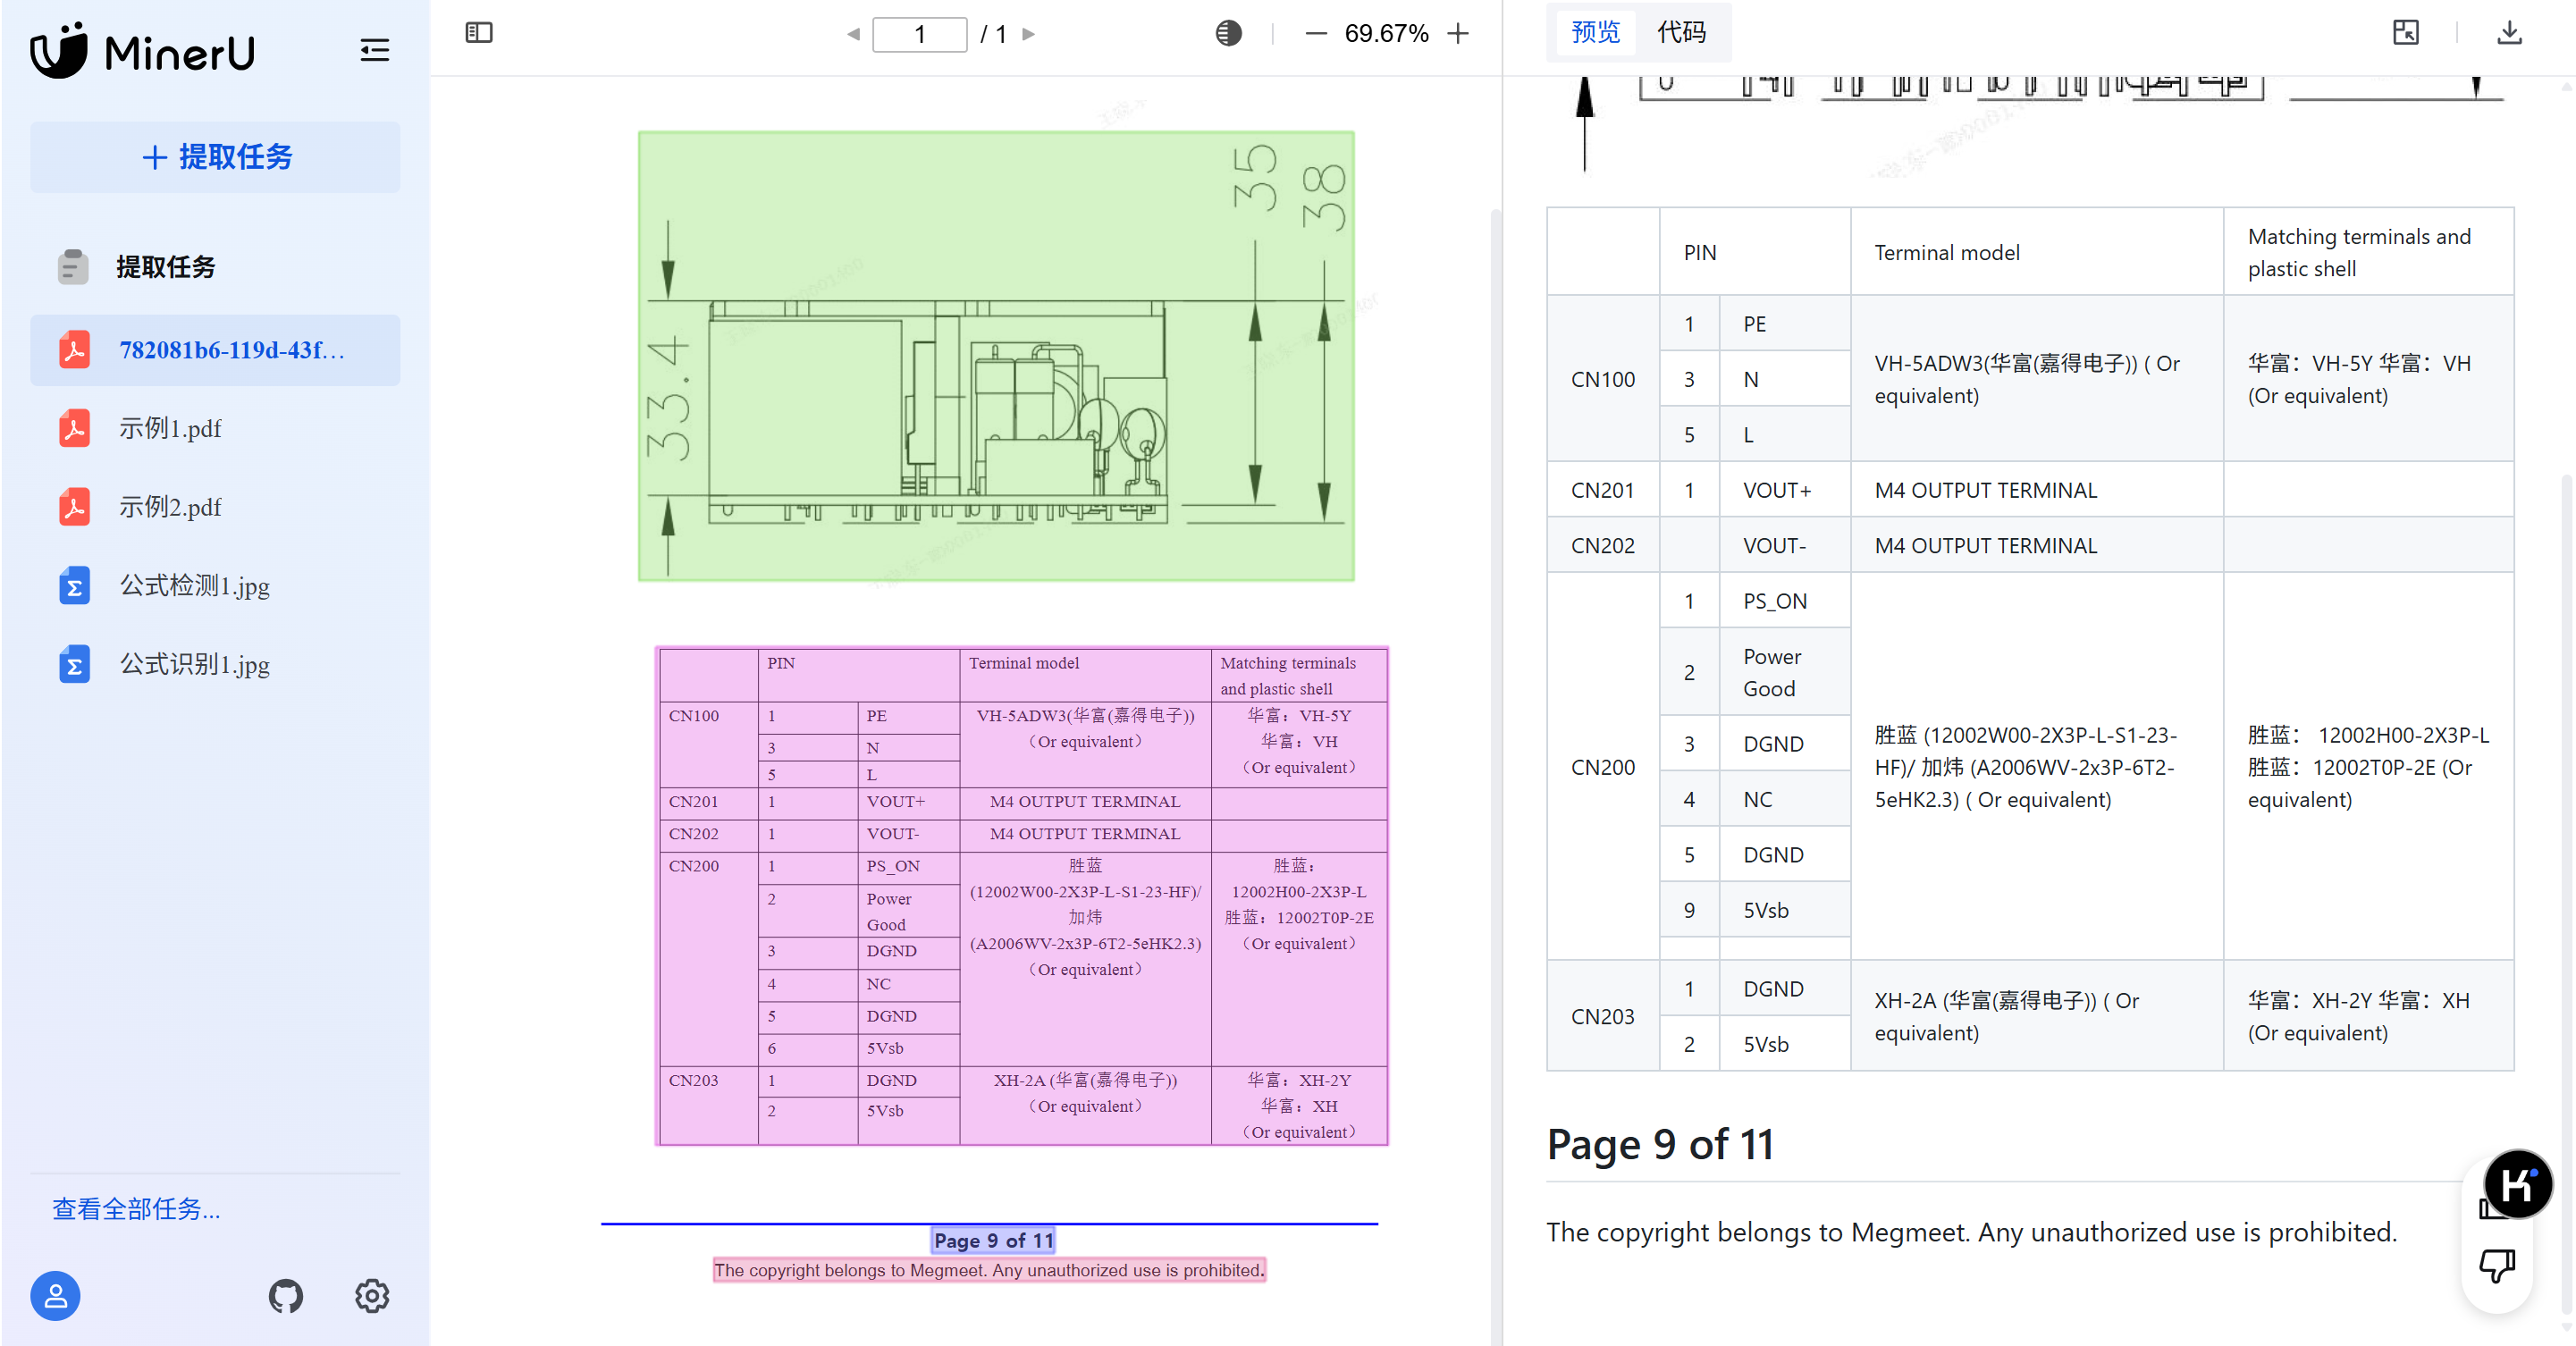